In [12]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy.stats.distributions import chi2 

from math import sqrt
import seaborn as sns
sns.set()

In [13]:
# load data
dengue_weather = pd.read_csv('../../assets/cleaned_comb_changi_weather.csv', parse_dates=[0], index_col='date')

In [14]:
# preview
dengue_weather.head()

,type_dengue,year,month,number,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),week
date,,,,,,,,,,,,,,,,,
2014-01-06,Dengue,2014,1,436.0,2014,1,6,31.2,10.0,10.8,11.6,25.3,27.1,23.9,6.1,25.6,2
2014-01-06,DHF,2014,1,1.0,2014,1,6,31.2,10.0,10.8,11.6,25.3,27.1,23.9,6.1,25.6,2
2014-01-13,Dengue,2014,1,479.0,2014,1,13,0.0,0.0,0.0,0.0,26.9,30.3,25.4,14.6,40.0,3
2014-01-13,DHF,2014,1,0.0,2014,1,13,0.0,0.0,0.0,0.0,26.9,30.3,25.4,14.6,40.0,3
2014-01-20,Dengue,2014,1,401.0,2014,1,20,0.0,0.0,0.0,0.0,25.7,29.1,23.6,11.7,38.2,4


In [15]:
# filter dengue cases only
dengue_only=dengue_weather.loc[dengue_weather['type_dengue']=='Dengue'].drop(columns=['type_dengue'])

In [16]:
# keep number 'number' only
dengue_only = dengue_only[['number']]

In [18]:
dengue_only.index = pd.to_datetime(dengue_only.index)
dengue_only = dengue_only.resample('W').sum()

In [19]:
# ADF to check stationary
result = adfuller(dengue_only['number'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.653206
p-value: 0.082492
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


In [20]:
# determine stationary
if result[1] > 0.05:
    print('The time series is not stationary.')
else:
    print('The time series is stationary.')

The time series is not stationary.


In [21]:
# difference if not stationary
if result[1] > 0.05:
    dengue_only_diff = dengue_only.diff().dropna()
else:
    dengue_only_diff = dengue_only.copy()

# ARIMA

In [22]:
# fit ARIMA
model = ARIMA(dengue_only_diff, order=(1, 1, 1))
model_fit = model.fit()

In [23]:
# generate forecasts
forecast = model_fit.predict(start=len(dengue_only_diff), end=len(dengue_only_diff) + 12)

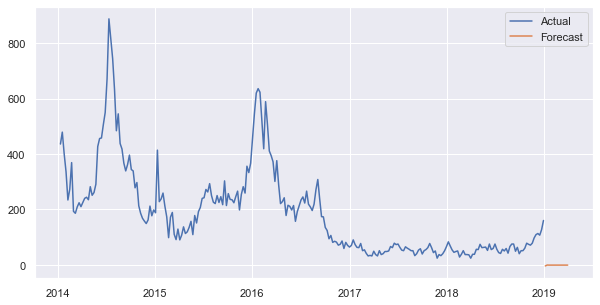

In [24]:
# plot forecasts
plt.figure(figsize=(10, 5))
plt.plot(dengue_only.index, dengue_only['number'])
plt.plot(forecast.index, forecast)
plt.legend(['Actual', 'Forecast'])
plt.show()

In [25]:
# model summary for ARIMA
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 number   No. Observations:                  259
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1362.059
Date:                Sun, 09 Apr 2023   AIC                           2730.118
Time:                        09:21:17   BIC                           2740.777
Sample:                    01-19-2014   HQIC                          2734.404
                         - 12-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0886      0.033     -2.699      0.007      -0.153      -0.024
ma.L1         -1.0000      7.393     -0.135      0.892     -15.491      13.491
sigma2      2205.1515   1.63e+04      0.135      0.8

# SARIMA Without Exo

In [26]:
# fit SARIMA model without exogenous variables
sarima_model = ARIMA(dengue_only_diff, order=(1,1,1), seasonal_order=(1,0,1,52))
sarima_fit = sarima_model.fit()

In [27]:
# generate forecasts
forecast = sarima_fit.predict(start=len(dengue_only_diff), end=len(dengue_only_diff) + 12)

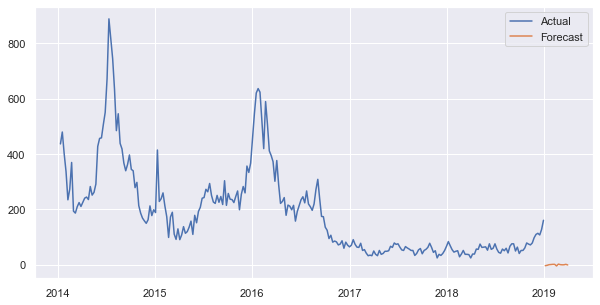

In [28]:
# plot forecasts
plt.figure(figsize=(10, 5))
plt.plot(dengue_only.index, dengue_only['number'])
plt.plot(forecast.index, forecast)
plt.legend(['Actual', 'Forecast'])
plt.show()

In [29]:
# model summary for SARIMA without Exo
print(sarima_fit.summary())

                                    SARIMAX Results                                     
Dep. Variable:                           number   No. Observations:                  259
Model:             ARIMA(1, 1, 1)x(1, 0, 1, 52)   Log Likelihood               -1361.460
Date:                          Sun, 09 Apr 2023   AIC                           2732.921
Time:                                  09:21:21   BIC                           2750.685
Sample:                              01-19-2014   HQIC                          2740.064
                                   - 12-30-2018                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0760      0.034     -2.206      0.027      -0.143      -0.008
ma.L1         -0.9979      0.140     -7.124      0.